In [1]:

#from dotenv import load_dotenv
#load_dotenv()

In [2]:
import os
api_key_status = "Loaded" if os.getenv("OPENAI_API_KEY") else "NOT FOUND - Check your .env file and environment."
print(f"OpenAI API Key status: {api_key_status}")

OpenAI API Key status: Loaded


In [3]:
# Imports
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph
from typing import TypedDict
from recursive_companion import MarketingCompanion, BugTriageCompanion, StrategyCompanion

In [4]:
# Wrap in a RunnableLambda
llm_fast  = "gpt-4o-mini"
llm_deep  = "gpt-4.1-mini" 

In [5]:
mkt   = MarketingCompanion(llm=llm_fast, temperature=0.8)
bug   = BugTriageCompanion(llm=llm_deep, temperature=0.3)
plan = StrategyCompanion(llm=llm_fast)

In [6]:
# Each node is now a first-class Runnable; you get built-in tracing, concurrency, retries, etc., without rewriting your engine.
mkt_node  = RunnableLambda(mkt)          # __call__ alias does the trick
bug_node  = RunnableLambda(bug)

In [7]:
# merge-lambda joins text views into one string
# note: LangGraph passes the entire upstream-state dict to a node.
# with out this function, two upstream nodes are piped straight into strategy, 
# so plan_node will receive a Python dict like {"engineering": "...", "marketing": "..."}.
# That's fine if your StrategyCompanion prompt expects that JSON blob, 
# but most of the time you'll want to concatenate the two strings first.
merge_node = RunnableLambda(
    lambda d: f"### Marketing\n{d['marketing']}\n\n### Engineering\n{d['engineering']}"
)
plan_node  = RunnableLambda(plan)

In [8]:
# Define the state schema for LangGraph
class GraphState(TypedDict):
    input: str
    marketing: str
    engineering: str
    merged: str
    final_plan: str

# Inline LangGraph example (fan-in)
# No extra prompts, no schema gymnastics: simply passing text between the callables the classes already expose.
graph = StateGraph(GraphState)
graph.add_node("marketing_agent",    lambda state: {"marketing": mkt_node.invoke(state["input"])})
graph.add_node("engineering_agent",  lambda state: {"engineering": bug_node.invoke(state["input"])})
graph.add_node("merge_agent",        lambda state: {"merged": merge_node.invoke(state)})
graph.add_node("strategy_agent",     lambda state: {"final_plan": plan_node.invoke(state["merged"])})

graph.add_edge("marketing_agent", "merge_agent")
graph.add_edge("engineering_agent", "merge_agent")
graph.add_edge("merge_agent", "strategy_agent")

graph.add_edge("__start__", "marketing_agent")
graph.add_edge("__start__", "engineering_agent")
graph.set_finish_point("strategy_agent")
workflow = graph.compile()

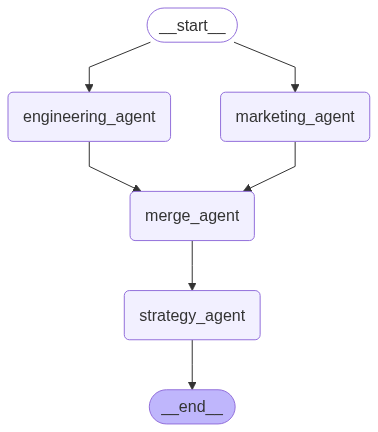

In [9]:
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [10]:
result = workflow.invoke(
    {"input": "App ratings fell to 3.2★ and uploads crash on iOS 17.2. Diagnose & propose next steps."}
)

In [38]:
  # 2. Stream execution to see order
for chunk in workflow.stream({"input": "your question"}):
    print(chunk)  # Shows which node produced what, in order

{'marketing_agent': {'marketing': 'I apologize for any misunderstanding. Here’s a revised summary of the current marketing challenge based on the provided information:\n\n**Current Marketing Challenge:**\n\nThe decline in app ratings, which has dropped from a peak of 4.5 stars to 3.2 stars over the past three months, not only reflects user dissatisfaction but also poses significant risks to user acquisition and long-term growth. A negative perception of our app can deter potential users and adversely affect retention rates among existing users.\n\n1. **Declining App Ratings**: The significant drop in ratings indicates growing user frustration, primarily driven by crashes and performance issues. This decline directly correlates with potential losses in user acquisition and long-term retention.\n\n2. **Crash Issues on iOS 17.2**: Users are encountering frequent crashes during uploads on iOS 17.2, which is a critical functionality. These crashes are a primary factor contributing to the de

In [34]:
plan.run_log[1]

{'draft': "### Integrated Overview of Marketing and Engineering Perspectives\n\n#### Marketing Insights\n1. **Decline in App Ratings**: The app's average rating has dropped to 3.2 stars, indicating significant user dissatisfaction. This decline correlates with recent issues, particularly following the release of iOS 17.2.\n2. **Upload Crashes**: Users report that the app crashes during uploads on iOS 17.2. This technical failure has led to negative reviews, directly impacting overall ratings.\n3. **User Feedback Analysis**: A systematic analysis of user reviews is crucial. Specific complaints include slow loading times for the image upload feature, failure of push notifications, and crashes when accessing settings. Prioritizing enhancements based on these insights will help address user concerns effectively.\n4. **Engagement Metrics**: Key performance indicators show concerning trends, such as a decrease in daily active users and average session lengths dropping from 10 minutes to unde

In [37]:
print(plan_node)

RunnableLambda(...)


In [ ]:
print(plan.transcript_as_markdown())

'--------------------------------------------------------------------------------\n## Initial Draft\n--------------------------------------------------------------------------------\n### Integrated Overview of Marketing and Engineering Perspectives\n\n**Marketing Observations:**\n1. **Decline in App Ratings**: The app\'s average rating has dropped to 3.2 stars, highlighting a significant user dissatisfaction linked to recent issues, especially post-release of iOS 17.2.\n2. **Upload Crashes**: Users report crashes during uploads on iOS 17.2, which are causing negative reviews and directly impacting ratings.\n3. **User Feedback Analysis**: Systematic analysis of user reviews is essential to identify recurring issues and prioritize necessary enhancements.\n4. **Engagement Metrics**: Key performance indicators such as session lengths and daily active users indicate possible user abandonment due to ongoing issues.\n5. **Demographic Insights**: Understanding the rating decline across differe

In [23]:
print(result)
print(type(result))
print(result.keys())
print(len(result))

{'input': 'App ratings fell to 3.2★ and uploads crash on iOS 17.2. Diagnose & propose next steps.', 'marketing': "The current marketing challenge revolves around a significant decline in app ratings, which have dropped to 3.2 stars, coinciding with the recent release of iOS 17.2. Additionally, users are experiencing issues with app uploads crashing on this operating system.\n\n**Current Issues:**\n\n1. **App Ratings**: The average rating of 3.2 stars indicates a growing user dissatisfaction. Specific complaints from users include slow loading times for the image upload feature, failure of the push notification system to deliver updates, and crashes when attempting to access the app's settings. These issues highlight serious user experience problems, likely exacerbated by bugs introduced in the latest iOS update.\n\n2. **Upload Crashes**: The app crashes for users during uploads on iOS 17.2, which directly correlates to negative reviews. For instance, users have reported that trying to 

In [28]:
final = result.get("final_plan", "")
print(type(final))
print(len(final))

<class 'str'>
5749


In [22]:
plan.similarity_threshold

0.97